# Frequency Stability

### Import libraries

In [1]:
import numpy as np
from analysis_functions import *
import allantools

2025-05-10 15:29:15.463232: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-10 15:29:15.467457: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-10 15:29:15.481070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-10 15:29:15.506287: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-10 15:29:15.512763: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-10 15:29:16.745775: W tensorflow/compiler/tf2tensorrt/utils/p

### Load Signal

In [2]:

data_dir = "../../data/"

sufix = 2
sample = 10  #0 - 9999
fs = 25e6  #sample_frequency
dt = 1/25e6 #period

samples, fcs = load_samples(data_dir,f"{sufix:03d}")

fc = fcs[sample]

# Obtain I[0] and Q[1] signals
i_signal = samples[sample,:,0]
q_signal = samples[sample,:,1]
iq_signal = np.array(i_signal + 1J*q_signal, dtype=complex)

# Calculate the magnitude and phase of the IQ signal
mag = np.sqrt(q_signal**2 + i_signal**2)
phase = np.arctan2(q_signal, i_signal)

# Unwrap phase to remove discontinuities at ±π
phase_unwrapped = np.unwrap(phase)

f_inst = np.diff(phase) * fs * ( 1 / (2 * np.pi))  # gamma*
y = (f_inst - fc) / fc # fractional instantaneous frequency deviation (y)

# print(fc)
# plt.plot(y)
# plt.show()
# plt.plot(f_inst)

print('Done')

Done


#### Spectral Density of y

When choosing Welch parameters for a short, high-rate series like your 11 000-point y[n] at 25 MHz, you’re always trading:

Frequency resolution Δf = fs/nperseg

Variance of the PSD estimate ∝ 1⁄K, where K≈nperseg−noverlap/N−noverlap is the number of independent segments.

For frequency-stability purposes you often care more about resolving low-offset noise (so seeing the PSD shape at the smallest possible Δf) than about extremely low variance. But you also need enough segments to smooth out the “boilerplate” noise of the estimate.

Recommended “sweet spot” for your data
- nperseg = 2048

  Δf ≃ 25 MHz / 2048 ≃ 12.2 kHz
  K≈(11000–1024)/(2048–1024)≈9 segments

- Good balance: ~10 kHz bins, ~9 averages

- noverlap = 1024 (50%)

- Standard choice to boost segment count without blowing up computation

- window = 'hann'

  Minimizes sidelobes (leakage) compared to rectangular

- detrend = 'constant'

  Removes DC bias but preserves all stochastic noise behavior

- scaling = 'density'

  Returns true PSD in units “per Hz”

With these, you’ll get ~9 smoothed estimates at ~12 kHz resolution—enough to see the 1/f and 1/f² regions if they slope up in the 10–100 kHz offset band.

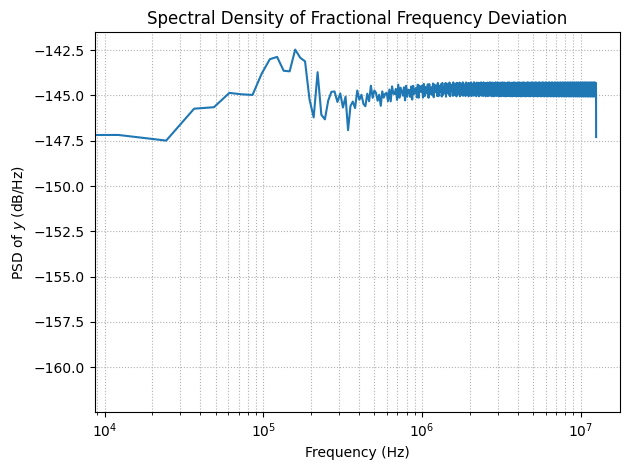

In [3]:
# Here we use 2048 samples per segment (you get ~5 segments with 50% overlap):
nperseg = 2048
noverlap = nperseg // 2

# Compute the PSD of y:
f, Pxx = welch(y,
               fs=fs,
               window='hann',
               nperseg=nperseg,
               noverlap=noverlap,
               scaling='density')

# Plot in dB/Hz vs. log-frequency:
plt.figure()
plt.semilogx(f, 10*np.log10(Pxx))
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD of $y$ (dB/Hz)")
plt.title("Spectral Density of Fractional Frequency Deviation")
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

#### sample variance of the fractional frequency fluctuations

Number of averaged samples (tau*fs): 500
Number of windows N: 21
Sample variance σ_y^2: 4.787e-11


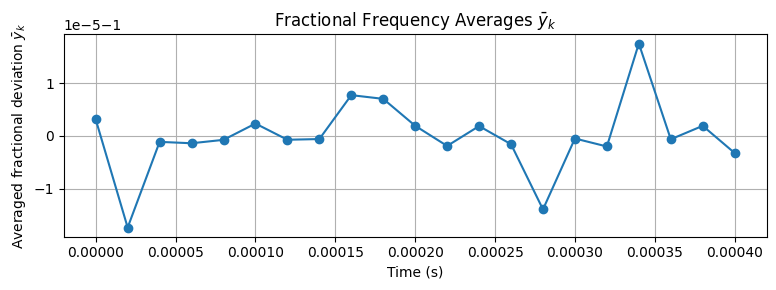

In [4]:
def sample_variance_frac_freq(y, fs, tau, T):
    """
    Compute the sample variance of the fractional frequency fluctuations
    according to the "second definition" in the time domain.
    
    Parameters
    ----------
    y_inst : 1D array
        Instantaneous fractional frequency deviation samples.
    fs : float
        Sampling rate (Hz).
    tau : float
        Averaging interval duration (s).
    T : float
        Repetition interval for measurements (s).
    
    Returns
    -------
    sigma2 : float
        Sample variance of the averaged fractional deviations.
    y_bar : 1D array
        Averaged fractional deviations ȳ_k.
    """
    m = int(np.round(tau * fs))   # samples in each average window
    M = int(np.round(T * fs))     # step between windows
    N = 1 + (len(y) - m) // M # number of windows
    y_bar = np.array([y[k*M : k*M + m].mean() for k in range(N)])
    sigma2 = np.var(y_bar, ddof=1)
    return sigma2, y_bar


# Parameters for stability measure
tau = 0.02e-3  # 1 ms averaging interval
T   = tau  # 1 ms repetition interval (contiguous averaging)

sigma2, y_bar = sample_variance_frac_freq(y, fs, tau, T)

# Display results
print(f"Number of averaged samples (tau*fs): {int(tau*fs)}")
print(f"Number of windows N: {len(y_bar)}")
print(f"Sample variance σ_y^2: {sigma2:.3e}")

# Plot ȳ_k sequence
plt.figure(figsize=(8,3))
plt.plot(np.arange(len(y_bar)) * T, y_bar, marker='o', linestyle='-')
plt.xlabel("Time (s)")
plt.ylabel("Averaged fractional deviation $\\bar{y}_k$")
plt.title("Fractional Frequency Averages $\\bar{y}_k$")
plt.grid(True)
plt.tight_layout()
plt.show()



#### Compute allan Variance

In [5]:
def allan_deviation_from_ybar(y_bar):
    """
    Compute the Allan deviation σ_y for a series of averaged fractional frequency
    deviations ȳ_k, according to:
    
        σ_y^2 = 1/2 ⟨ (ȳ_{k+1} - ȳ_k)^2 ⟩
        σ_y   = sqrt(σ_y^2)
    
    Parameters
    ----------
    y_bar : 1D array
        Averaged fractional frequency deviations (ȳ_k).
    
    Returns
    -------
    sigma_y : float
        Allan deviation of the series.
    """
    # Compute successive differences
    diffs = np.diff(y_bar)
    # Compute Allan variance
    sigma2 = 0.5 * np.mean(diffs**2)

    return sigma2

sigma2_y = allan_deviation_from_ybar(y_bar)
print(f"Allan deviation σ_y = {sigma2_y:.3e} (fractional)")

Allan deviation σ_y = 4.767e-11 (fractional)


### Compute Allan Deviation

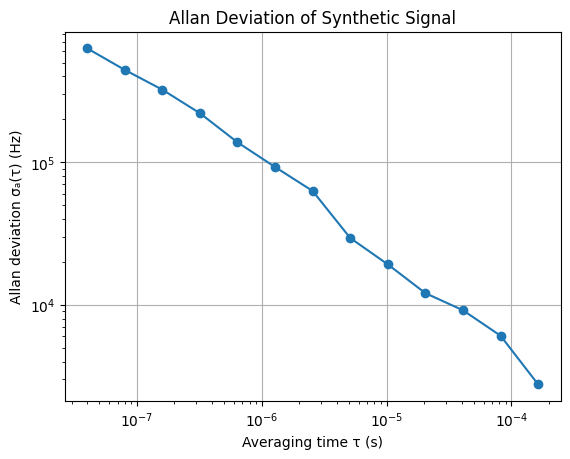

In [31]:
# Using e.g. allantools library:
import allantools
taus, adevs, _, _ = allantools.oadev(inst_freq, rate=fs, data_type='freq')

# Plot Allan deviation
plt.loglog(taus, adevs, marker='o')
plt.xlabel("Averaging time τ (s)")
plt.ylabel("Allan deviation σₐ(τ) (Hz)")
plt.title("Allan Deviation of Synthetic Signal")
plt.grid(True)
plt.show()
